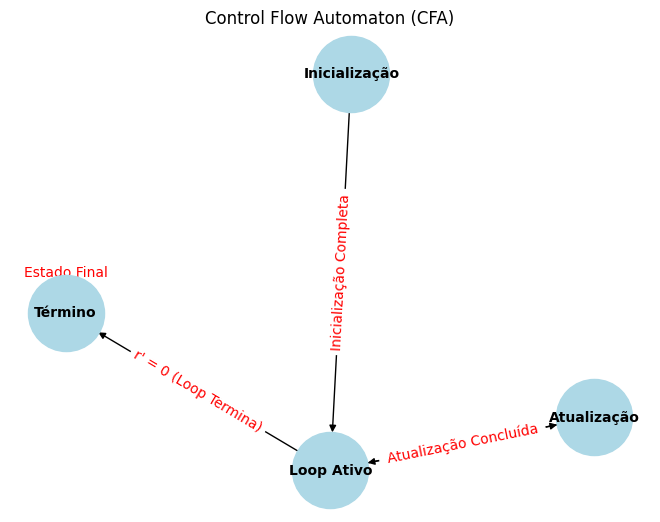

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

def construir_cfa():
    # Criar o grafo orientado
    cfa = nx.DiGraph()
    
    # Adicionar os locais (nós)
    locais = {
        0: "Inicialização",
        1: "Loop Ativo",
        2: "Atualização",
        3: "Término"
    }
    for local, desc in locais.items():
        cfa.add_node(local, label=desc)
    
    # Adicionar as transições (arestas)
    cfa.add_edge(0, 1, cond="Inicialização Completa")
    cfa.add_edge(1, 2, cond="r' != 0 (Loop Continua)")
    cfa.add_edge(2, 1, cond="Atualização Concluída")
    cfa.add_edge(1, 3, cond="r' = 0 (Loop Termina)")
    cfa.add_edge(3, 3, cond="Estado Final")
    
    # Desenhar o grafo
    pos = nx.spring_layout(cfa)
    nx.draw(cfa, pos, with_labels=True, labels=locais, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(cfa, 'cond')
    nx.draw_networkx_edge_labels(cfa, pos, edge_labels=edge_labels, font_color="red")
    
    plt.title("Control Flow Automaton (CFA)")
    plt.show()
    
    return cfa

cfa = construir_cfa()


In [10]:
from z3 import *

n = 32  # Tamanho dos BitVectors

# Declarar variáveis para um estado
def declarar_estado(i):
    return {
        "pc": BitVec(f"pc_{i}", n),
        "r": BitVec(f"r_{i}", n),
        "s": BitVec(f"s_{i}", n),
        "t": BitVec(f"t_{i}", n),
        "r_": BitVec(f"r__{i}", n),
        "s_": BitVec(f"s__{i}", n),
        "t_": BitVec(f"t__{i}", n),
        "q": BitVec(f"q_{i}", n)
    }

# Condições iniciais
def inicializar_estado(estado, a, b):
    return And(
        estado["pc"] == 0,
        estado["r"] == a,
        estado["s"] == 1,
        estado["t"] == 0,
        estado["r_"] == b,
        estado["s_"] == 0,
        estado["t_"] == 1,
        estado["q"] == 0
    )

# Transições
def transicao(curr, prox):
    return Or(
        # Transição 0 -> 1
        And(curr["pc"] == 0, prox["pc"] == 1, prox["r"] == curr["r"], prox["r_"] == curr["r_"]),
        # Transição 1 -> 2
        And(curr["pc"] == 1, curr["r_"] != 0, prox["pc"] == 2),
        # Transição 2 -> 1 (atualização)
        And(
            curr["pc"] == 2, prox["pc"] == 1,
            prox["q"] == curr["r"] / curr["r_"],
            prox["r"] == curr["r_"],
            prox["r_"] == curr["r"] - (curr["r_"] * curr["q"]),
            prox["s"] == curr["s_"],
            prox["s_"] == curr["s"] - (curr["s_"] * curr["q"]),
            prox["t"] == curr["t_"],
            prox["t_"] == curr["t"] - (curr["t_"] * curr["q"])
        ),
        # Transição 1 -> 3
        And(curr["pc"] == 1, curr["r_"] == 0, prox["pc"] == 3)
    )

# Verificar segurança (r ≠ 0 e sem overflow)
def invariantes(estado):
    max_val = (1 << n) - 1  # Valor máximo para evitar overflow
    return And(
        estado["r"] != 0,
        ULT(estado["r"], max_val), ULT(estado["r_"], max_val),
        ULT(estado["s"], max_val), ULT(estado["s_"], max_val),
        ULT(estado["t"], max_val), ULT(estado["t_"], max_val),
        ULT(estado["q"], max_val)
    )

# Construção do sistema de equações
def construir_sistema(a, b, k):
    estados = [declarar_estado(i) for i in range(k)]
    solver = Solver()
    
    # Condição inicial
    solver.add(inicializar_estado(estados[0], a, b))
    
    # Transições e invariantes
    for i in range(k - 1):
        solver.add(transicao(estados[i], estados[i + 1]))
        solver.add(invariantes(estados[i]))
    
    # Verificar último estado
    solver.add(invariantes(estados[-1]))
    
    return solver

# Testar o sistema
a, b, k = 3, 6, 5  # Parâmetros
solver = construir_sistema(a, b, k)
if solver.check() == sat:
    print("Sistema seguro: Não há estados de erro.")
else:
    print("Sistema inseguro: Estado de erro encontrado.")


Sistema seguro: Não há estados de erro.
